In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import tensorflow as tf
import numpy as np
import pickle
import os

# Define the directory containing CIFAR-10 batches
data_dir = "cifar-10-batches-py"

# Function to unpickle the dataset files
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load all training batches
X_train, y_train = [], []
for i in range(1, 6):
    batch = unpickle(os.path.join(data_dir, f"data_batch_{i}"))
    X_train.append(batch[b'data'])
    y_train.extend(batch[b'labels'])



In [ ]:
print(f"Number of batches loaded: {len(X_train)}")
print(f"Total images loaded: {sum(len(batch) for batch in X_train)}")
print(f"Total labels loaded: {len(y_train)}")

Number of batches loaded: 5
Total images loaded: 50000
Total labels loaded: 50000


In [ ]:
# Convert list of image batches into a single NumPy array
X_train = np.vstack(X_train).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
y_train = np.array(y_train).reshape(-1, 1)

# Print final shapes
print(f"Shape of X_train: {X_train.shape} \t Shape of Y_train: {y_train.shape}")

Shape of X_train: (50000, 32, 32, 3) 	 Shape of Y_train: (50000, 1)


In [ ]:
# Load the test batch
test_batch = unpickle(os.path.join(data_dir, "test_batch"))
x_test = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
y_test = np.array(test_batch[b'labels']).reshape(-1, 1)

# Print final shapes
print(f"Shape of X_train: {X_train.shape} \t Shape of Y_train: {y_train.shape}")
print(f"Shape of X_test: {x_test.shape} \t Shape of Y_test: {y_test.shape}")

Shape of X_train: (50000, 32, 32, 3) 	 Shape of Y_train: (50000, 1)
Shape of X_test: (10000, 32, 32, 3) 	 Shape of Y_test: (10000, 1)


In [ ]:
#Normalize pixel values to the range [0,1]
X_train, x_test = X_train / 255.0, x_test / 255.0

# Print final shapes
print(f"Shape of X_train: {X_train.shape} \t Shape of Y_train: {y_train.shape}")
print(f"Shape of X_test: {x_test.shape} \t Shape of Y_test: {y_test.shape}")

Shape of X_train: (50000, 32, 32, 3) 	 Shape of Y_train: (50000, 1)
Shape of X_test: (10000, 32, 32, 3) 	 Shape of Y_test: (10000, 1)


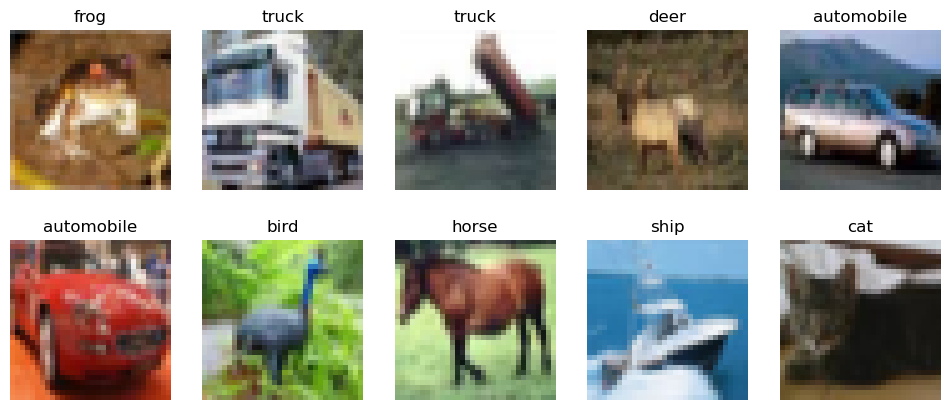

In [ ]:
import matplotlib.pyplot as plt

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Function to plot sample images
def plot_images(images, labels, num_images=10):
    plt.figure(figsize=(12, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i][0]])
        plt.axis('off')
    plt.show()

plot_images(X_train, y_train)


/var/folders/bf/g5mqnsyx7_91k089_h9wc8mh0000gn/T/ipykernel_83314/2020924768.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


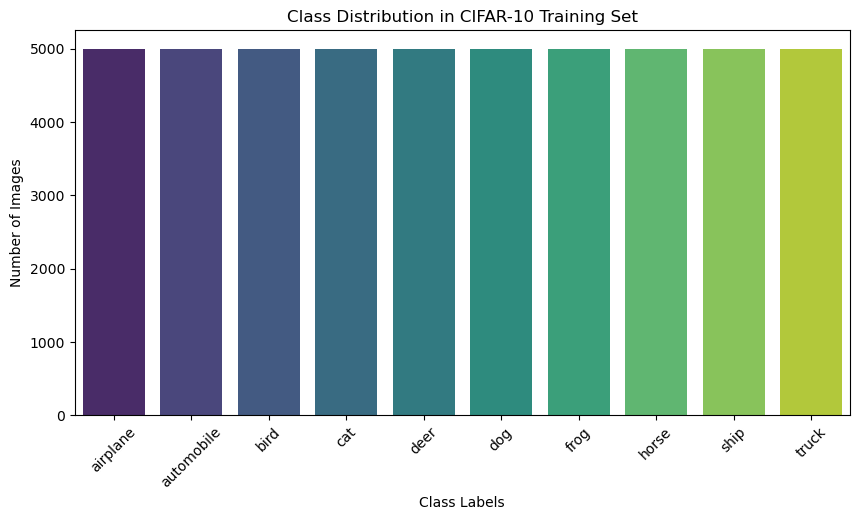

In [ ]:
import seaborn as sns
import numpy as np

unique, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(10, 5))
sns.barplot(x=unique, y=counts, palette="viridis")
plt.xticks(ticks=unique, labels=class_names, rotation=45)
plt.xlabel("Class Labels")
plt.ylabel("Number of Images")
plt.title("Class Distribution in CIFAR-10 Training Set")
plt.show()


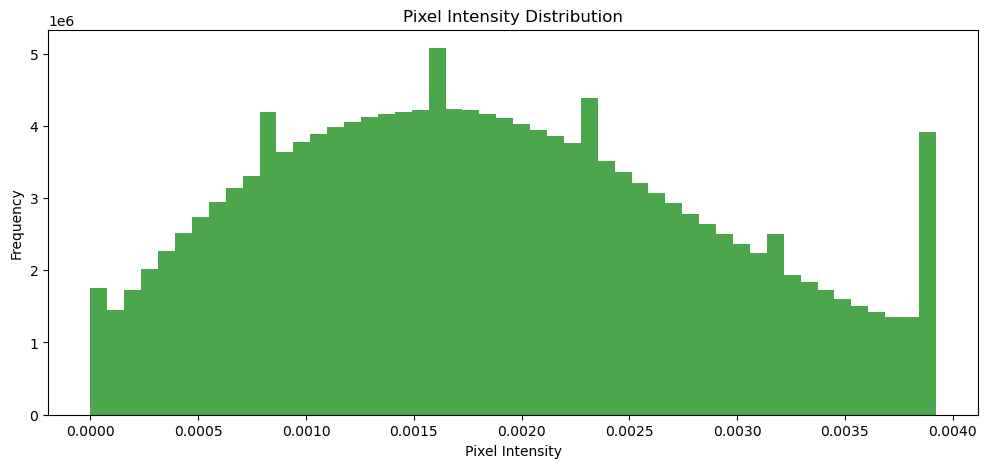

In [ ]:
# Flatten images to 1D for histogram plotting
plt.figure(figsize=(12, 5))
plt.hist((X_train / 255.0).flatten(), bins=50, color='green', alpha=0.7)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Define function to create the CNN model
def create_cnn_model(activation):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation=activation, padding='same', input_shape=(32,32,3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(256, (3,3), activation=activation, padding='same'),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=activation),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Callback to stop training when training error ≤ 25%
class StopAt25PercentError(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        training_error = 1 - logs["accuracy"]
        if training_error <= 0.25:
            print(f"\nStopping training at epoch {epoch + 1} with training error {training_error:.4f}")
            self.model.stop_training = True

# Function to train model and capture error & time per epoch
def train_model(activation):
    model = create_cnn_model(activation)
    history = []
    times_per_epoch = []

    for epoch in range(50):
        start_time = time.time()
        hist = model.fit(X_train, y_train, epochs=1, batch_size=64, validation_data=(x_test, y_test), verbose=1)
        end_time = time.time()

        times_per_epoch.append(end_time - start_time)
        history.append(1 - hist.history['accuracy'][0])

        if history[-1] <= 0.25:
            print(f"\nStopping training at epoch {epoch + 1} with training error {history[-1]:.4f}")
            break

    return history, times_per_epoch




In [ ]:

errors_relu, times_relu = train_model('relu')

782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 71ms/step - accuracy: 0.3743 - loss: 1.6913 - val_accuracy: 0.6095 - val_loss: 1.0877
782/782 ━━━━━━━━━━━━━━━━━━━━ 54s 70ms/step - accuracy: 0.6341 - loss: 1.0298 - val_accuracy: 0.6906 - val_loss: 0.8832
782/782 ━━━━━━━━━━━━━━━━━━━━ 67s 86ms/step - accuracy: 0.7240 - loss: 0.7865 - val_accuracy: 0.7018 - val_loss: 0.8408
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - accuracy: 0.7806 - loss: 0.6228 - val_accuracy: 0.7278 - val_loss: 0.7920

Stopping training at epoch 4 with training error 0.2218


In [ ]:
errors_tanh, times_tanh = train_model('tanh')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 78ms/step - accuracy: 0.4528 - loss: 1.5424 - val_accuracy: 0.6108 - val_loss: 1.1190
782/782 ━━━━━━━━━━━━━━━━━━━━ 58s 75ms/step - accuracy: 0.6451 - loss: 1.0147 - val_accuracy: 0.6369 - val_loss: 1.0547
782/782 ━━━━━━━━━━━━━━━━━━━━ 123s 158ms/step - accuracy: 0.7051 - loss: 0.8543 - val_accuracy: 0.6824 - val_loss: 0.9484
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - accuracy: 0.7534 - loss: 0.7155 - val_accuracy: 0.6968 - val_loss: 0.9102
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.7930 - loss: 0.6001 - val_accuracy: 0.7085 - val_loss: 0.8862

Stopping training at epoch 5 with training error 0.2165


In [ ]:
errors_sigmoid, times_sigmoid = train_model('sigmoid')

782/782 ━━━━━━━━━━━━━━━━━━━━ 60s 75ms/step - accuracy: 0.1004 - loss: 2.4015 - val_accuracy: 0.1000 - val_loss: 2.3282
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 76ms/step - accuracy: 0.1980 - loss: 2.1284 - val_accuracy: 0.3886 - val_loss: 1.6866
782/782 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.3938 - loss: 1.6530 - val_accuracy: 0.4242 - val_loss: 1.5512
782/782 ━━━━━━━━━━━━━━━━━━━━ 68s 86ms/step - accuracy: 0.4548 - loss: 1.4942 - val_accuracy: 0.4740 - val_loss: 1.4525
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.4968 - loss: 1.3970 - val_accuracy: 0.5101 - val_loss: 1.3445
782/782 ━━━━━━━━━━━━━━━━━━━━ 61s 78ms/step - accuracy: 0.5248 - loss: 1.3171 - val_accuracy: 0.5317 - val_loss: 1.2927
782/782 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - accuracy: 0.5493 - loss: 1.2504 - val_accuracy: 0.5565 - val_loss: 1.2404
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.5800 - loss: 1.1764 - val_accuracy: 0.5696 - val_loss: 1.2044
782/782 ━━━━━━━━━━━━━━━━━━━━ 208s 266ms/step - a

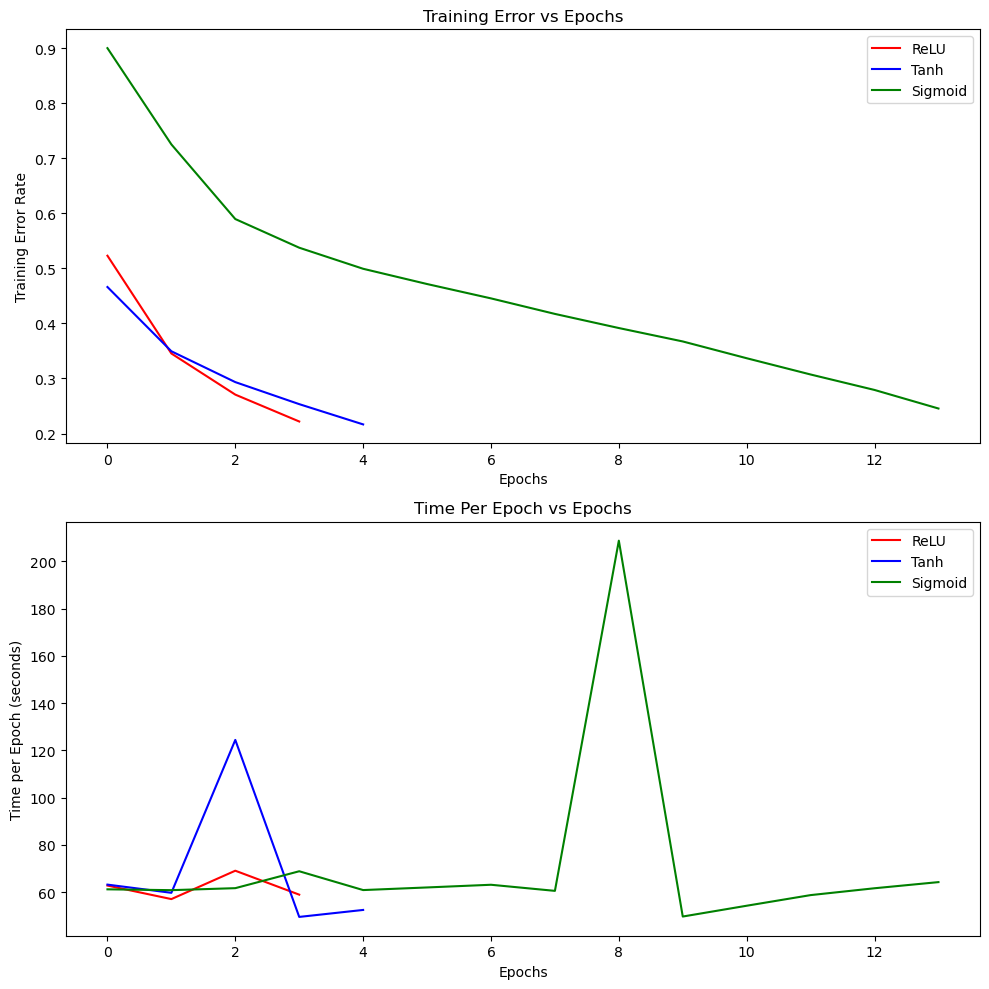

In [ ]:

fig, axs = plt.subplots(2, 1, figsize=(10, 10))
colors = {"ReLU": "red", "Tanh": "blue", "Sigmoid": "green"}

# Training Error Graph
axs[0].plot(errors_relu, color=colors["ReLU"], label="ReLU")
axs[0].plot(errors_tanh, color=colors["Tanh"], label="Tanh")
axs[0].plot(errors_sigmoid, color=colors["Sigmoid"], label="Sigmoid")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Training Error Rate")
axs[0].legend()
axs[0].set_title("Training Error vs Epochs")

# Time Per Epoch Graph
axs[1].plot(times_relu, color=colors["ReLU"], label="ReLU")
axs[1].plot(times_tanh, color=colors["Tanh"], label="Tanh")
axs[1].plot(times_sigmoid, color=colors["Sigmoid"], label="Sigmoid")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Time per Epoch (seconds)")
axs[1].legend()
axs[1].set_title("Time Per Epoch vs Epochs")

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time


def create_cnn_model(activation):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation=activation, padding='same', input_shape=(32,32,3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(256, (3,3), activation=activation, padding='same'),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=activation),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Callback to stop training when training error ≤ 25%
class StopAt25PercentError(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        training_error = 1 - logs["accuracy"]
        if training_error <= 0.25:
            print(f"\nStopping training at epoch {epoch + 1} with training error {training_error:.4f}")
            self.model.stop_training = True

# Function to train model and capture error & time per epoch
def train_model(activation):
    model = create_cnn_model(activation)
    history = []
    times_per_epoch = []

    for epoch in range(50):
        start_time = time.time()
        hist = model.fit(X_train, y_train, epochs=1, batch_size=64, validation_data=(x_test, y_test), verbose=1)
        end_time = time.time()

        times_per_epoch.append(end_time - start_time)
        history.append(1 - hist.history['accuracy'][0])

        if history[-1] <= 0.25:
            print(f"\nStopping training at epoch {epoch + 1} with training error {history[-1]:.4f}")
            break

    return history, times_per_epoch



In [ ]:

errors_relu, times_relu = train_model('relu')


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


782/782 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - accuracy: 0.3642 - loss: 1.6994 - val_accuracy: 0.6002 - val_loss: 1.1158
782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/step - accuracy: 0.6385 - loss: 1.0155 - val_accuracy: 0.6783 - val_loss: 0.9190
782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - accuracy: 0.7295 - loss: 0.7744 - val_accuracy: 0.7134 - val_loss: 0.8148
782/782 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.7806 - loss: 0.6211 - val_accuracy: 0.7344 - val_loss: 0.7667

Stopping training at epoch 4 with training error 0.2190


In [ ]:
errors_tanh, times_tanh = train_model('tanh')


782/782 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - accuracy: 0.4566 - loss: 1.5375 - val_accuracy: 0.6099 - val_loss: 1.1104
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 68ms/step - accuracy: 0.6414 - loss: 1.0318 - val_accuracy: 0.6520 - val_loss: 1.0111
782/782 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - accuracy: 0.7006 - loss: 0.8626 - val_accuracy: 0.6569 - val_loss: 0.9976
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - accuracy: 0.7408 - loss: 0.7490 - val_accuracy: 0.6993 - val_loss: 0.8932
782/782 ━━━━━━━━━━━━━━━━━━━━ 57s 73ms/step - accuracy: 0.7868 - loss: 0.6143 - val_accuracy: 0.7087 - val_loss: 0.8827

Stopping training at epoch 5 with training error 0.2238


In [ ]:
errors_sigmoid, times_sigmoid = train_model('sigmoid')

782/782 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step - accuracy: 0.0960 - loss: 2.3964 - val_accuracy: 0.1000 - val_loss: 2.3223
782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 71ms/step - accuracy: 0.1100 - loss: 2.3100 - val_accuracy: 0.2713 - val_loss: 1.9621
782/782 ━━━━━━━━━━━━━━━━━━━━ 64s 81ms/step - accuracy: 0.3225 - loss: 1.8381 - val_accuracy: 0.3987 - val_loss: 1.6295
782/782 ━━━━━━━━━━━━━━━━━━━━ 68s 87ms/step - accuracy: 0.4313 - loss: 1.5746 - val_accuracy: 0.4606 - val_loss: 1.4840
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.4772 - loss: 1.4395 - val_accuracy: 0.4915 - val_loss: 1.4014
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.5111 - loss: 1.3500 - val_accuracy: 0.5113 - val_loss: 1.3517
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 91ms/step - accuracy: 0.5367 - loss: 1.2786 - val_accuracy: 0.5343 - val_loss: 1.2737
782/782 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - accuracy: 0.5678 - loss: 1.2056 - val_accuracy: 0.5442 - val_loss: 1.2642
782/782 ━━━━━━━━━━━━━━━━━━━━ 56s 72ms/step - acc

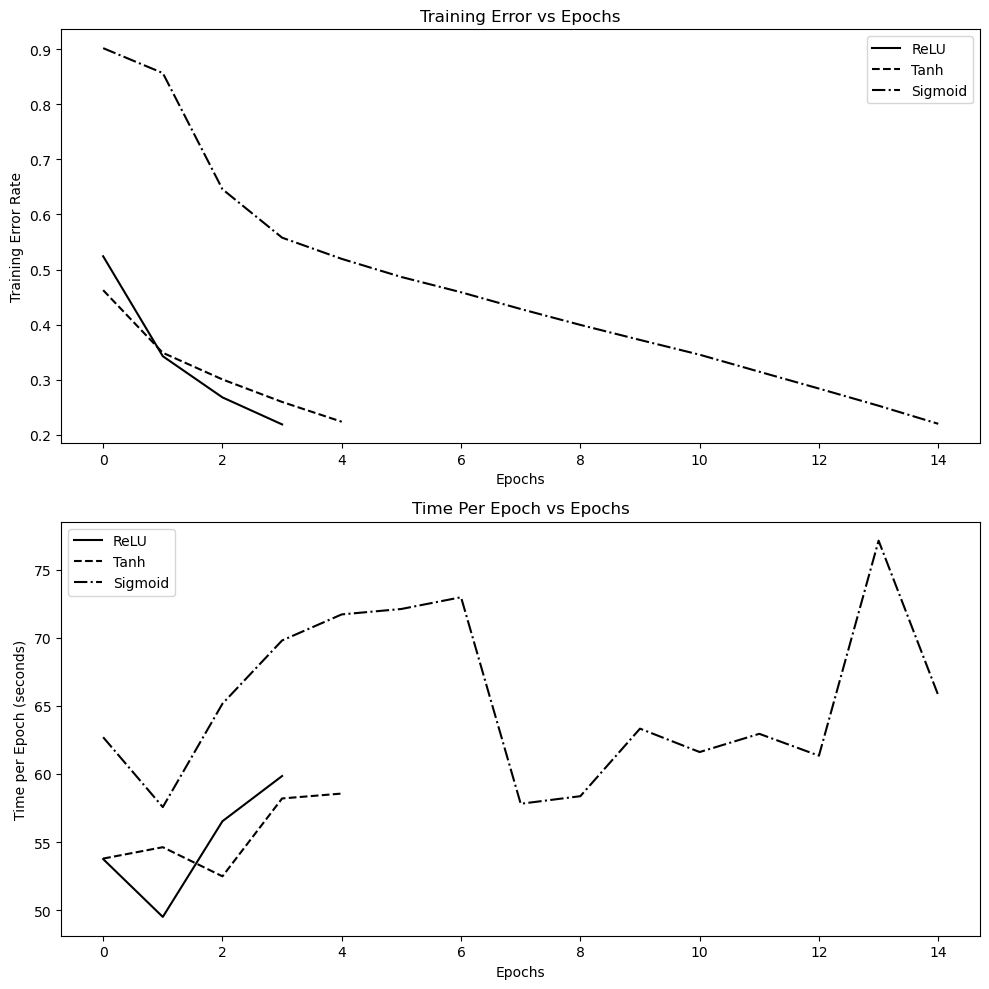

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Training Error Graph
axs[0].plot(errors_relu, 'k-', label="ReLU")
axs[0].plot(errors_tanh, 'k--', label="Tanh")
axs[0].plot(errors_sigmoid, 'k-.', label="Sigmoid")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Training Error Rate")
axs[0].legend()
axs[0].set_title("Training Error vs Epochs")


# Time Per Epoch Graph
axs[1].plot(times_relu, 'k-', label="ReLU")
axs[1].plot(times_tanh, 'k--', label="Tanh")
axs[1].plot(times_sigmoid, 'k-.', label="Sigmoid")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Time per Epoch (seconds)")
axs[1].legend()
axs[1].set_title("Time Per Epoch vs Epochs")

plt.tight_layout()
plt.show()


In [1]:
#SGD

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Define function to create the CNN model
def create_cnn_model(activation):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation=activation, padding='same', input_shape=(32,32,3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation=activation, padding='same'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(256, (3,3), activation=activation, padding='same'),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=activation),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Callback to stop training when training error ≤ 25%
class StopAt25PercentError(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        training_error = 1 - logs["accuracy"]
        if training_error <= 0.25:
            print(f"\nStopping training at epoch {epoch + 1} with training error {training_error:.4f}")
            self.model.stop_training = True

# Function to train model and capture error & time per epoch
def train_model(activation):
    model = create_cnn_model(activation)
    history = []
    times_per_epoch = []

    for epoch in range(50):
        start_time = time.time()
        hist = model.fit(X_train, y_train, epochs=1, batch_size=64, validation_data=(x_test, y_test), verbose=1)
        end_time = time.time()

        times_per_epoch.append(end_time - start_time)
        history.append(1 - hist.history['accuracy'][0])
        if history[-1] <= 0.25:
            print(f"\nStopping training at epoch {epoch + 1} with training error {history[-1]:.4f}")
            break

    return history, times_per_epoch




In [ ]:
errors_relu, times_relu = train_model('relu')


782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.2658 - loss: 1.9779 - val_accuracy: 0.4903 - val_loss: 1.3829
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.5362 - loss: 1.2957 - val_accuracy: 0.5986 - val_loss: 1.1406
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.6377 - loss: 1.0203 - val_accuracy: 0.6648 - val_loss: 0.9541
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 33ms/step - accuracy: 0.7089 - loss: 0.8223 - val_accuracy: 0.7014 - val_loss: 0.8528
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.7600 - loss: 0.6824 - val_accuracy: 0.7090 - val_loss: 0.8520

Stopping training at epoch 5 with training error 0.2440


In [ ]:
errors_tanh, times_tanh = train_model('tanh')


782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.3786 - loss: 1.7214 - val_accuracy: 0.5914 - val_loss: 1.1542
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.6136 - loss: 1.1002 - val_accuracy: 0.6419 - val_loss: 1.0181
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.6736 - loss: 0.9293 - val_accuracy: 0.6690 - val_loss: 0.9532
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.7165 - loss: 0.8146 - val_accuracy: 0.6829 - val_loss: 0.9334
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.7532 - loss: 0.7087 - val_accuracy: 0.7106 - val_loss: 0.8560

Stopping training at epoch 5 with training error 0.2495


In [ ]:
errors_sigmoid, times_sigmoid = train_model('sigmoid')

782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.0986 - loss: 2.3474 - val_accuracy: 0.1000 - val_loss: 2.3064
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.1010 - loss: 2.3048 - val_accuracy: 0.1000 - val_loss: 2.3033
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.1038 - loss: 2.3034 - val_accuracy: 0.1000 - val_loss: 2.3034
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.1005 - loss: 2.3034 - val_accuracy: 0.1000 - val_loss: 2.3031
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.0995 - loss: 2.3034 - val_accuracy: 0.1000 - val_loss: 2.3030
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 43ms/step - accuracy: 0.0975 - loss: 2.3031 - val_accuracy: 0.1000 - val_loss: 2.3030
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.0980 - loss: 2.3033 - val_accuracy: 0.1000 - val_loss: 2.3027
782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.0986 - loss: 2.3031 - val_accuracy: 0.1000 - val_loss: 2.3028
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - acc

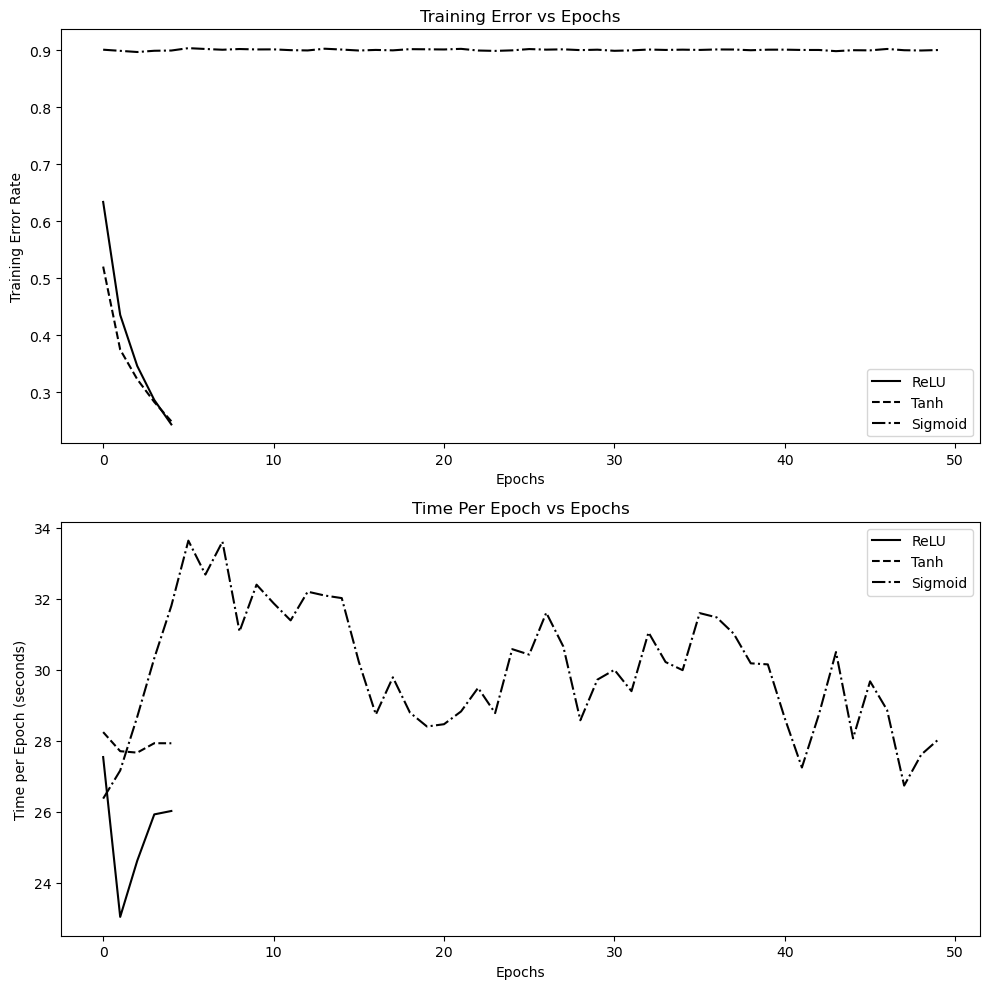

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Training Error Graph
axs[0].plot(errors_relu, 'k-', label="ReLU")
axs[0].plot(errors_tanh, 'k--', label="Tanh")
axs[0].plot(errors_sigmoid, 'k-.', label="Sigmoid")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Training Error Rate")
axs[0].legend()
axs[0].set_title("Training Error vs Epochs")


# Time Per Epoch Graph
axs[1].plot(times_relu, 'k-', label="ReLU")
axs[1].plot(times_tanh, 'k--', label="Tanh")
axs[1].plot(times_sigmoid, 'k-.', label="Sigmoid")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Time per Epoch (seconds)")
axs[1].legend()
axs[1].set_title("Time Per Epoch vs Epochs")

plt.tight_layout()
plt.show()
